#Image Classification


##Data import and loading

In [2]:
#-----------IMPORT DATASET--------------#
from google.colab import drive
import os
drive.mount('/content/drive',force_remount=True)
datadir='/content/drive/MyDrive/dataset/'

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/data_10_class_middle_1.zip'

In [4]:
datadir = '/content/data_10_class_middle/'
my_folders = os.listdir(datadir+"train/")

##Transfer learning

In [5]:
datadir = '/content/data_10_class_middle/'
trainingset = datadir+'train_mini/'
testset = datadir + 'test/'
valset = datadir + 'val_mini/'
models_dir = datadir + 'models/'
results_dir = datadir + 'results/'
def savemodel(model,problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model.save(filename)
    print("\nModel saved on file %s\n" %filename)

def savehistory(history,problem):
    filename = os.path.join(results_dir, '%s.hist' %problem)
    with open(filename, 'wb') as f:
        pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)
    print("\nHystory saved on file %s\n" %filename)

def loadhistory(problem):
    filename = os.path.join(results_dir, '%s.hist' %problem)
    with open(filename, 'rb') as f:
        history = pickle.load(f)
    print("\nHystory loaded from file %s\n" %filename)
    return history

In [6]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,\
                         UpSampling2D, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle 

batch_size=10 

train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=45
    )

train_generator = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True)

val_datagen = ImageDataGenerator(rescale = 1. / 255)
val_generator = val_datagen.flow_from_directory(
    directory=trainingset,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True)

test_datagen = ImageDataGenerator(
     rescale = 1. / 255)
test_generator = test_datagen.flow_from_directory(
     directory=testset,
     target_size=(224, 224),
     color_mode="rgb",
     batch_size=batch_size,
     class_mode="categorical",
     shuffle=False)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape
print(train_generator.class_indices)

Found 4500 images belonging to 10 classes.
Found 4500 images belonging to 10 classes.


FileNotFoundError: ignored

In [15]:
#Pretraind or not
init_weights='imagenet' #if you want to use the pretrained model
#init_weights=None       #No pretrained


###Load MobileNet


In [ ]:
# Load mobileNet model 

def load_mobileNet_features(input_shape, init_weights=None):
    
    # define input tensor
    input0 = Input(shape=input_shape)

    # load mobileNet model (possibly pretrained model on imagenet) without the final dense layers (include_top=False)
    mobileNet_model = tf.keras.applications.mobilenet.MobileNet(include_top=False, weights=init_weights, input_tensor=input0)
    
    feature_extractor = tf.keras.models.Model(inputs=input0, outputs=mobileNet_model.output, name="mobileNet")

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

    feature_extractor.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

    return feature_extractor

mobileNet_feat_model = load_mobileNet_features(input_shape, init_weights)
mobileNet_feat_model.summary()

In [ ]:
def transferNet_MobileNet(input_shape, num_classes, output_layer_name, trainable_layers):
    
    # load the pre-trained model
    feature_extractor = load_mobileNet_features(input_shape, init_weights=init_weights)

    # get the original input layer tensor
    input_t = feature_extractor.get_layer(index=0).input

    #set the feture extractor layers as non-trainable
    for idx,layer in enumerate(feature_extractor.layers):
      if layer.name in trainable_layers:
        layer.trainable = True
      else:
        layer.trainable = False

    # get the output tensor from a layer of the feature extractor
    output_extractor = feature_extractor.get_layer(name = output_layer_name).output
    
    #output_extractor = MaxPooling2D(pool_size=(4,4))(output_extractor)

    # # flat the output of a Conv layer
    flatten = Flatten()(output_extractor) 
    flatten_norm = BatchNormalization()(flatten)
    
    # add the final output layer
    dense3 = BatchNormalization()(flatten_norm)
    dense3 = Dense(10, activation='softmax')(dense3)
    
    model = tf.keras.models.Model(inputs=input_t, outputs=dense3, name="transferNet")
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-9)
    model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model



# choose the layer from which you can get the features (block5_pool the end, glob_pooling to get the pooled version of the output)
name_output_extractor = "conv_pw_13_relu"
trainable_layers = ["conv_pw_13"]

# build the transfer model
MobileNet = transferNet_MobileNet(input_shape, num_classes, name_output_extractor, trainable_layers)
history=None


###Load inceptionV3


In [20]:
# Load incv3 model 


def load_inceptionV3_features(input_shape, init_weights=None):
    
    # define input tensor
    input0 = Input(shape=input_shape)

    # load inceptionV3 model (possibly pretrained model on imagenet) without the final dense layers (include_top=False)
    inceptionV3_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights=init_weights, input_tensor=input0)
    
    feature_extractor = tf.keras.models.Model(inputs=input0, outputs=inceptionV3_model.output, name="InceptionV3")

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    feature_extractor.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

    return feature_extractor

InceptionV3_feat_model = load_inceptionV3_features(input_shape, init_weights)
InceptionV3_feat_model.summary()


Model: "InceptionV3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_190 (Batch  (None, 111, 111, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                       

In [21]:
def transferNet_InceptionV3(input_shape, num_classes, output_layer_name, trainable_layers):
    
    # load the pre-trained model
    feature_extractor = load_inceptionV3_features(input_shape, init_weights=init_weights)

    # get the original input layer tensor
    input_t = feature_extractor.get_layer(index=0).input

    #set the feture extractor layers as non-trainable
    for idx,layer in enumerate(feature_extractor.layers):
      if layer.name in trainable_layers:
        layer.trainable = True
      else:
        layer.trainable = False

    # get the output tensor from a layer of the feature extractor
    output_extractor = feature_extractor.get_layer(name = output_layer_name).output
    
    #output_extractor = MaxPooling2D(pool_size=(4,4))(output_extractor)

    # # flat the output of a Conv layer
    flatten = Flatten()(output_extractor) 
    flatten_norm = BatchNormalization()(flatten)

    # # add a Dense layer
    # dense1 = Dropout(0.4)(flatten_norm)
    # dense1 = Dense(200, activation='relu')(dense1)
    # dense1 = BatchNormalization()(dense1)
    
    # # add a Dense layer
    # dense2 = Dropout(0.6)(flatten_norm)
    # dense2 = Dense(100, activation='relu')(dense2)
    # dense2 = BatchNormalization()(dense2)

    # add the final output layer
    dense3 = BatchNormalization()(flatten_norm)
    dense3 = Dense(10, activation='softmax')(dense3)
    
    model = tf.keras.models.Model(inputs=input_t, outputs=dense3, name="transferNet")
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model



# choose the layer from which you can get the features (block5_pool the end, glob_pooling to get the pooled version of the output)
name_output_extractor = "mixed10"
trainable_layers = ["conv2d_375"]

# build the transfer model
InceptionV3 = transferNet_InceptionV3(input_shape, num_classes, name_output_extractor, trainable_layers)
history=None

Model: "transferNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_284 (Batch  (None, 111, 111, 32  96         ['conv2d_282[0][0]']             
 Normalization)                 )                                                       

###Load vgg16

In [ ]:
# Load vgg16 model 

def load_vgg16_features(input_shape, init_weights=None):
    
    # define input tensor
    input0 = Input(shape=input_shape)

    # load eff net model (possibly pretrained model on imagenet) without the final dense layers (include_top=False)
    vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights=init_weights, input_tensor=input0)
    
    feature_extractor = tf.keras.models.Model(inputs=input0, outputs=vgg16_model.output, name="vgg16")

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    feature_extractor.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

    return feature_extractor

#vgg16_model = load_vgg16_features(input_shape)
#vgg16_model.summary()

In [ ]:
def transferNet_vgg16(input_shape, num_classes, output_layer_name, trainable_layers):
    
    # load the pre-trained model
    feature_extractor = load_vgg16_features(input_shape, init_weights='imagenet')
    feature_extractor.trainable=False
    # get the original input layer tensor
    input_t = feature_extractor.get_layer(index=0).input

    
    

    # get the output tensor from a layer of the feature extractor
    output_extractor = feature_extractor.get_layer(name = output_layer_name).output
    
    #output_extractor = MaxPooling2D(pool_size=(4,4))(output_extractor)

    # flat the output of a Conv layer
    flatten = Flatten()(output_extractor) 
    flatten_norm = BatchNormalization()(flatten)

    #add the final output layer
    dense3 = BatchNormalization()(flatten_norm)
    dense3 = Dense(10, activation='softmax')(dense3)
    
    model = tf.keras.models.Model(inputs=input_t, outputs=dense3, name="transferNet")
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) 
    model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

    return model

    # choose the layer from which you can get the features (block5_pool the end, glob_pooling to get the pooled version of the output)
name_output_extractor = "block5_pool"
trainable_layers = ["block5_conv3"]

# build the transfer model
vgg16 = transferNet_vgg16(input_shape, num_classes, name_output_extractor, trainable_layers)
history=None

58889256/58889256 [==============================] - 2s 0us/step


##CNN from scratch

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, ReLU
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the CNN model
CNN = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), input_shape=(224, 224, 3)),  # Add a convolutional layer with 16 filters and 3x3 kernel, and specify the input shape
    BatchNormalization(),  # Add a BatchNormalization layer to normalize the activations of the previous layer
    LeakyReLU(),  # Add a LeakyReLU activation function to introduce some nonlinearity
    tf.keras.layers.MaxPooling2D(2, 2),  # Add a max pooling layer to reduce the spatial dimensions of the output
    tf.keras.layers.Dropout(rate=0.15),  # Add a dropout layer to randomly drop out 15% of the activations
    tf.keras.layers.Conv2D(32, (3,3)),  # Add another convolutional layer with 32 filters and 3x3 kernel
    BatchNormalization(),
    LeakyReLU(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Conv2D(64, (3,3)),
    BatchNormalization(),
    LeakyReLU(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Flatten(),  # Add a flatten layer to convert the output to a 1D tensor
    tf.keras.layers.Dense(512),  # Add a fully connected layer with 512 neurons
    BatchNormalization(),
    LeakyReLU(),
    tf.keras.layers.Dense(10, activation='softmax')  # Add a final output layer with 10 neurons and softmax activation
])

# Compile the model with RMSprop optimizer
optimizer = RMSprop(learning_rate=0.001)  # Specify the optimizer to use with a learning rate of 0.001
CNN.compile(loss='categorical_crossentropy',  # Use categorical crossentropy as the loss function
              optimizer=optimizer,  # Use the specified optimizer
              metrics=['accuracy'])  # Track the accuracy metric during training

##Training


In [22]:
#chosen_model=[MobileNet,InceptionV3,vgg16]
#model choice
model=InceptionV3
chosen_model='InceptionV3'

In [ ]:
model.summary()

In [23]:
# fit the transferNet on the training data

stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=8)
mc = callbacks.ModelCheckpoint(chosen_model+'.h5', monitor='val_accuracy', mode='max', save_best_only=True)

steps_per_epoch = train_generator.n//train_generator.batch_size
val_steps = val_generator.n//val_generator.batch_size
epochs = 10

try:
    transfer_history = model.fit(train_generator, epochs=epochs, verbose=1,
                                 callbacks=[stopping,mc],
                                 steps_per_epoch=steps_per_epoch,
                                 validation_data=val_generator,
                                 validation_steps=val_steps)
except KeyboardInterrupt:
    pass


# Save trained model and hystory
problemname = chosen_model

if not history:
    history = transfer_history.history
else:
    history['loss'].extend(transfer_history.history['loss'])
    history['accuracy'].extend(transfer_history.history['accuracy'])
    history['val_loss'].extend(transfer_history.history['val_loss'])
    history['val_accuracy'].extend(transfer_history.history['val_accuracy'])

savemodel(model,problemname)
savehistory(transfer_history,problemname)

Epoch 1/10
450/450 [==============================] - 41s 75ms/step - loss: 1.8514 - accuracy: 0.8622 - val_loss: 0.5191 - val_accuracy: 0.9682
Epoch 2/10
450/450 [==============================] - 34s 75ms/step - loss: 0.7187 - accuracy: 0.9564 - val_loss: 0.1820 - val_accuracy: 0.9862
Epoch 3/10
450/450 [==============================] - 31s 70ms/step - loss: 0.7556 - accuracy: 0.9618 - val_loss: 0.4121 - val_accuracy: 0.9818
Epoch 4/10
450/450 [==============================] - 32s 72ms/step - loss: 0.7227 - accuracy: 0.9684 - val_loss: 0.3109 - val_accuracy: 0.9869
Epoch 5/10
450/450 [==============================] - 38s 85ms/step - loss: 0.7228 - accuracy: 0.9722 - val_loss: 0.0952 - val_accuracy: 0.9947
Epoch 6/10
450/450 [==============================] - 32s 70ms/step - loss: 0.4841 - accuracy: 0.9800 - val_loss: 0.1431 - val_accuracy: 0.9933
Epoch 7/10
450/450 [==============================] - 33s 73ms/step - loss: 0.4203 - accuracy: 0.9827 - val_loss: 0.2941 - val_accuracy:

##Results



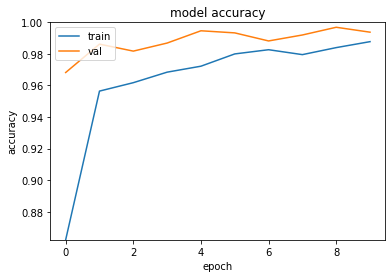

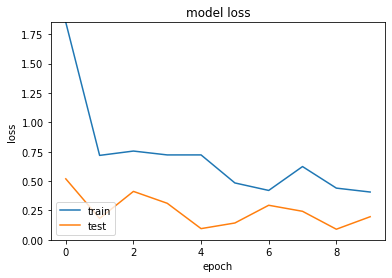

In [26]:
# summarize history for accuracy
import numpy as np

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(np.min(history['accuracy']), 1.0)
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0.0, np.max(history['loss']))
plt.legend(['train', 'test'], loc='lower left')
plt.show()

In [27]:
from keras.models import load_model
saved_model = load_model('InceptionV3.h5')

In [28]:
#precision recall f-score
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

# accuracy
score = saved_model.evaluate(test_generator,verbose=1,steps=val_steps)
print("Test loss: %f" %score[0])
print("Test accuracy: %f" %score[1])

preds = model.predict(test_generator,verbose=1,steps=val_steps)
Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes
print('%s' %str(Ypred.shape))
print('%s' %str(Ytest.shape))

print(classification_report(Ytest, Ypred, digits=3))



200/450 [============>.................] - ETA: 8s - loss: 2.0843 - accuracy: 0.9590

450/450 [==============================] - 8s 15ms/step - loss: 2.0843 - accuracy: 0.9590
Test loss: 2.084317
Test accuracy: 0.959000
200/450 [============>.................] - ETA: 13s

450/450 [==============================] - 12s 24ms/step
(2000,)
(2000,)
              precision    recall  f1-score   support

           0      0.902     0.920     0.911       200
           1      0.955     0.965     0.960       200
           2      0.918     0.955     0.936       200
           3      0.940     0.935     0.937       200
           4      0.980     0.960     0.970       200
           5      0.955     0.955     0.955       200
           6      0.990     0.965     0.977       200
           7      0.936     0.955     0.946       200
           8      0.985     0.985     0.985       200
           9      0.990     0.950     0.969       200

    accuracy                          0.955      2000
   macro avg      0.955     0.955     0.955      2000
weighted avg      0.955     0.955     0.955      2000



[[184   1   5   3   3   3   0   0   0   1]
 [  3 193   1   2   0   0   1   0   0   0]
 [  3   3 191   1   0   1   1   0   0   0]
 [  5   3   2 187   1   1   0   1   0   0]
 [  2   1   3   2 192   0   0   0   0   0]
 [  2   0   5   2   0 191   0   0   0   0]
 [  3   1   1   2   0   0 193   0   0   0]
 [  2   0   0   0   0   4   0 191   3   0]
 [  0   0   0   0   0   0   0   2 197   1]
 [  0   0   0   0   0   0   0  10   0 190]]


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

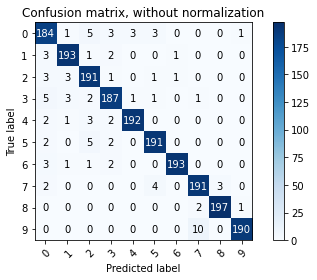

In [29]:
#confusion matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [0,1,2,3,4,5,6,7,8,9]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
y_pred = np.argmax(preds, axis=1)
y_test = test_generator.classes  # shuffle=False in test_data
cm = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)
print(cm)
plot_confusion_matrix(y_test, y_pred, classes=my_folders, normalize=False)

In [30]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_generator.classes, Ypred)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(my_folders[k[0]],my_folders[k[1]],k[2],k[2]*100.0/test_generator.n))

True                 Predicted         	errors 	err % 
------------------------------------------------------------------
Corn_(maize)___Northern_Leaf_Blight ->  Tomato___Target_Spot  	10 	0.50 % 
Orange___Haunglongbing_(Citrus_greening) ->  Tomato___Spider_mites Two-spotted_spider_mite  	5 	0.25 % 
Grape___healthy  ->  Apple___Cedar_apple_rust  	5 	0.25 % 
Tomato___Spider_mites Two-spotted_spider_mite ->  Apple___Cedar_apple_rust  	5 	0.25 % 
Tomato___Target_Spot ->  Grape___healthy   	4 	0.20 % 
Tomato___Spider_mites Two-spotted_spider_mite ->  Potato___Early_blight  	3 	0.15 % 
Tomato___Spider_mites Two-spotted_spider_mite ->  Grape___healthy   	3 	0.15 % 
Potato___Early_blight ->  Apple___Cedar_apple_rust  	3 	0.15 % 
Grape___Esca_(Black_Measles) ->  Tomato___Spider_mites Two-spotted_spider_mite  	3 	0.15 % 
Tomato___Target_Spot ->  Potato___Late_blight  	3 	0.15 % 
Apple___Cedar_apple_rust ->  Tomato___Spider_mites Two-spotted_spider_mite  	3 	0.15 % 
Apple___Cedar_apple_rust ->  

In [31]:
import sklearn.metrics 
from sklearn.metrics import classification_report

preds = saved_model.predict(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_data

print(classification_report(Ytest, Ypred, labels=None, target_names=my_folders, digits=3))

199/450 [============>.................] - ETA: 16s

450/450 [==============================] - 15s 28ms/step
                                               precision    recall  f1-score   support

Tomato___Spider_mites Two-spotted_spider_mite      0.942     0.890     0.915       200
                 Grape___Esca_(Black_Measles)      0.932     0.960     0.946       200
                     Apple___Cedar_apple_rust      0.984     0.945     0.964       200
     Orange___Haunglongbing_(Citrus_greening)      0.919     0.960     0.939       200
                        Potato___Early_blight      0.985     0.970     0.977       200
                              Grape___healthy      0.943     0.985     0.963       200
                         Tomato___Late_blight      0.980     0.965     0.972       200
                         Tomato___Target_Spot      0.979     0.940     0.959       200
                         Potato___Late_blight      0.957     0.990     0.973       200
          Corn_(maize)___Northern_Leaf_Blight      0.975     0.985     0